# Business Decision Signature Detection Use Case


Notebook to create a VGG 16 model to classify between image with **no signature** and with **signature**

In [124]:
# import the required libraries
import os
import random
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import History
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator

import cv2

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### Defining folders containing data sets


In [126]:
training_folder = '/content/drive/My Drive/model_data/train'
validation_folder = '/content/drive/My Drive/model_data/val'

In [127]:
test_folder = '/content/drive/My Drive/model_data/test'

In [133]:
# Defining some common parameters
SHAPE = (224,224, 3) # to ensure the shape of all images is same
batch_size = 256 # to define a uniform batch size

### Required Functions : model & image labeling


In [158]:
def vgg_model():
    """
    Function to create a modified version of VGG 16 model
    """
    # defining the model to use
    vgg = vgg16.VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape = SHAPE)
    
    for layer in vgg.layers:
        layer.trainable = False
    
    # adding pooling and dense layers
    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="softmax")(x)

    # create and compile the model
    model = Model(vgg.input, x)
    model.compile(optimizer = SGD(learning_rate=0.0001, momentum=0.9),
                  loss = "categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model

In [79]:
def predict_label(image):
  """
  Function to return a label 0 or 1, given and image to classify.
  """
  
  img = load_img(
      image, target_size=(SHAPE[0, SHAPE[1])
                )

  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, 0) # Create a batch

  # get the weights for each class
  predictions = model.predict(img_array)
  
  # get the confidence score for the prediction
  score = tf.nn.softmax(predictions[0])

  # get the label for the predicted clas : 0/1
  # depending on which class has the higher score
  label = np.argmax(score)

  # generating class name for the label
  if label == 1 :   cls = 'signature'
  else :   cls = 'no_signature'
  
  return label



Rescaling the train, validation and test data


In [145]:
train_gen = ImageDataGenerator(rescale=1/255)

val_gen = ImageDataGenerator(rescale=1/255)


In [146]:
test_gen = ImageDataGenerator(rescale=1/255)

### Creating FLOW GENERATORS to train and test the model

In [147]:

# indentifying number of classes for test and validation sets
train_generator = train_gen.flow_from_directory(
            directory = training_folder,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training',
            seed = 33
)


Found 833 images belonging to 2 classes.


In [148]:
# validation set 
validation_generator = val_gen.flow_from_directory(
            directory = validation_folder,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            
            seed = 33
)

Found 288 images belonging to 2 classes.


In [149]:
# testing set

test_generator = test_gen.flow_from_directory(
            '/content/drive/My Drive/model_data', classes=['test'],
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = 1,
            class_mode = None,
            shuffle = False,
            seed = 33
)

Found 251 images belonging to 1 classes.


Getting the names for the classes

In [150]:
class_names = train_generator.class_indices
print(class_names)

{'no_sig': 0, 'sig': 1}


In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

### Training the VGG16 model

In [159]:
# calling the model
model = vgg_model()

In [160]:
# fitting the model 
history = model.fit(train_generator, 
                    validation_data = validation_generator, 
                    epochs = 25,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size)


Epoch 1/25
3/3 [==============================] - 441s 154s/step - loss: 0.7886 - accuracy: 0.3917 - val_loss: 0.8312 - val_accuracy: 0.2847
Epoch 2/25
3/3 [==============================] - 433s 151s/step - loss: 0.7703 - accuracy: 0.4073 - val_loss: 0.8077 - val_accuracy: 0.2847
Epoch 3/25
3/3 [==============================] - 433s 199s/step - loss: 0.7532 - accuracy: 0.3969 - val_loss: 0.7785 - val_accuracy: 0.2847
Epoch 4/25
3/3 [==============================] - 432s 198s/step - loss: 0.7307 - accuracy: 0.4055 - val_loss: 0.7475 - val_accuracy: 0.2847
Epoch 5/25
3/3 [==============================] - 428s 149s/step - loss: 0.7137 - accuracy: 0.4090 - val_loss: 0.7197 - val_accuracy: 0.3333
Epoch 6/25
3/3 [==============================] - 423s 148s/step - loss: 0.7041 - accuracy: 0.3934 - val_loss: 0.6966 - val_accuracy: 0.4792
Epoch 7/25
3/3 [==============================] - 436s 200s/step - loss: 0.6929 - accuracy: 0.5303 - val_loss: 0.6764 - val_accuracy: 0.6562
Epoch 8/25
3/

In [161]:
# model details
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Model Evaluation

Visualizing the loss and accuracy relations


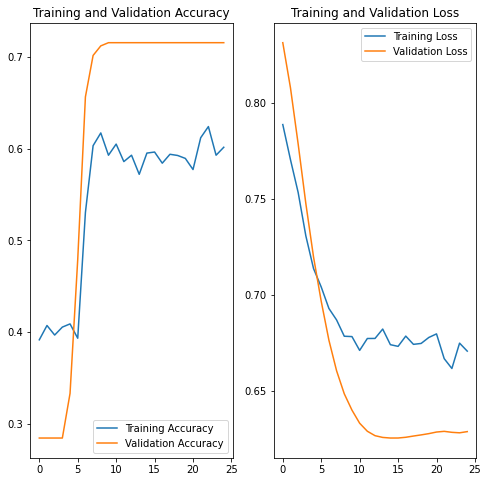

In [162]:
# plotting the curves for training vs. validation accuracy and loss

epochs = 25

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [163]:
# getting the validation scores
val_score = model.evaluate(validation_generator)
print('Val Loss:', val_score[0])
print('Val accuracy:', val_score[1])

2/2 [==============================] - 143s 16s/step - loss: 0.6288 - accuracy: 0.7153
Val Loss: 0.6287772059440613
Val accuracy: 0.7152777910232544


### Model Evaluation continued


Retrieving Validation labels from the generator


In [164]:
val_num = validation_generator.samples

label_val = []
for i in range((val_num // validation_generator.batch_size)+1):
    X,y = validation_generator.next()
    label_val.append(y)
        
label_val = np.argmax(np.vstack(label_val), axis=1)

label_val.shape



(288,)

In [166]:
# making predictions for validation set
predict_val = np.argmax(model.predict(validation_generator),axis=1)

Performance checking on Validation Data

In [167]:
# Classification Report
print("Classification report")
target_names = ['No_signature', 'Signature']
print(classification_report(label_val, predict_val, target_names = target_names))

Classification report
              precision    recall  f1-score   support

No_signature       0.00      0.00      0.00        82
   Signature       0.72      1.00      0.83       206

    accuracy                           0.72       288
   macro avg       0.36      0.50      0.42       288
weighted avg       0.51      0.72      0.60       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
# Confusion Matrix
print("Confusion Matrix")
print(confusion_matrix(label_val, predict_val))

Confusion Matrix
[[  0  82]
 [  0 206]]


### Generating predictions for Test dataset

In [169]:
# getiing predictions using the model
STEP_SIZE_TEST = test_generator.samples//test_generator.batch_size

# reset before every predict run
test_generator.reset()
pred = model.predict(test_generator,
              steps = STEP_SIZE_TEST,
              verbose=1)

251/251 [==============================] - 141s 561ms/step


In [170]:
# getting the array for labels of predicted classes
predicted_class_indices = np.argmax(pred,axis=1)


In [171]:
# getting the labels for names of predicted classes
predictions = [labels[k] for k in predicted_class_indices]

Storing the results in list using indiviual file prediction


In [172]:
Id_list = []
Expected_list = []
count = 0

for root, direc, files in os.walk(test_folder):
        for f in files:
            # getting each image from the test folder
            img_path = os.path.join(test_folder,f)

            # adding filename to list
            Id_list.append(f[:-4])

            # calling predict_label(image_path) function to get the label
            # adding label to corresponding list
            Expected_list.append(predict_label(img_path))
            count += 1
            


Creating a csv file to save the labels


In [173]:
 # populating in a dataframe
labels_df = pd.DataFrame(list(zip(Id_list,Expected_list)),
                            columns = ['Id','Expected']
                            )
# saving results to a csv file label.csv
labels_df.to_csv(r'/content/drive/MyDrive/labels1.csv', index = False)


### Saving the model

In [176]:
model.save(r'/content/drive/MyDrive/sig_classifier.h5')

#### End of notebook